In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data, wb
import scipy.optimize as sco
import scipy.interpolate as itp

In [2]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [3]:
symbols = ['ABBV', 'WNS', 'PSX', 'PNM', 'BVN']
noa = len(symbols)

In [4]:
from datetime import datetime, timedelta
N = 200
days_ago_N = datetime.now() - timedelta(days=N)
days_ago_N_string = days_ago_N.strftime('%Y-%m-%d')

In [5]:
%%time
df = pd.DataFrame()
start = days_ago_N_string
for symbol in symbols:
    print(symbol)
    df[symbol] = data.DataReader(symbol, 'yahoo', start)['Close']

ABBV
WNS
PSX
PNM
BVN
Wall time: 5.47 s


In [6]:
df.head()

,ABBV,WNS,PSX,PNM,BVN
Date,,,,,
2017-04-10,64.970001,28.389999,78.050003,37.650002,12.14
2017-04-11,64.180000,29.000000,77.879997,37.750000,11.95
2017-04-12,64.370003,28.930000,77.379997,38.099998,12.12
2017-04-13,64.129997,28.950001,76.669998,37.400002,12.36
2017-04-17,64.309998,29.320000,77.010002,38.000000,12.35


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


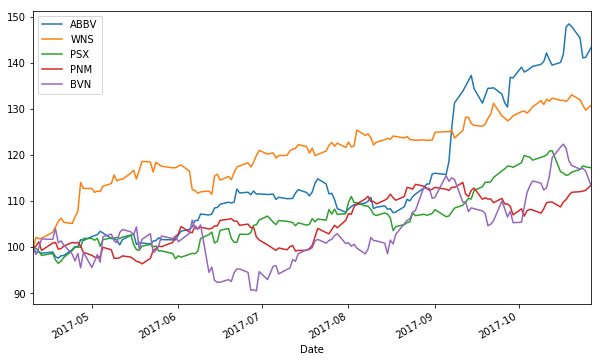

In [7]:
(df / df.ix[0] * 100).plot(figsize=(10,6))

In [8]:
rets = np.log(df / df.shift(1))

In [9]:
rets.mean() * 252

ABBV    0.653763
WNS     0.487551
PSX     0.288636
PNM     0.230310
BVN     0.226431
dtype: float64

In [10]:
rets.cov() * 252

,ABBV,WNS,PSX,PNM,BVN
ABBV,0.037973,0.004144,0.001250,0.005982,-0.005626
WNS,0.004144,0.027848,-0.000765,-0.002931,-0.009757
PSX,0.001250,-0.000765,0.022823,0.001276,0.001219
PNM,0.005982,-0.002931,0.001276,0.019079,0.000349
BVN,-0.005626,-0.009757,0.001219,0.000349,0.104846


In [11]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([ 0.2253063 ,  0.13676911,  0.2013657 ,  0.25315458,  0.1834043 ])

In [12]:
np.dot(weights.T, rets.mean()) * 252

0.37193275875611143

In [13]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.0082275557869781347

In [14]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.090705875151382204

In [15]:
prets = []
pvols = []
for p in range(2500):
    weights = np.random.random(noa)
    weights = weights / np.sum(weights)
    prets.append(np.dot(weights.T, rets.mean() * 252))
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))))
    
prets = np.array(prets)
pvols = np.array(pvols)

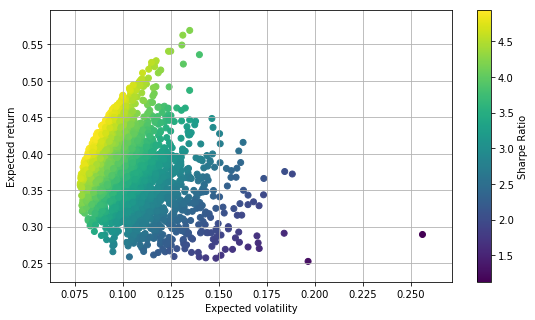

In [16]:
plt.figure(figsize=(9, 5))
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.grid(True)
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe Ratio')

In [17]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.dot(weights.T, rets.mean() * 252)
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [18]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [19]:
cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0,1) for x in range(noa))

In [20]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)

Wall time: 44 ms


In [21]:
opts

     fun: -4.967600555387962
     jac: array([ 0.00041097,  0.0012747 ,  0.00087786, -0.00284868, -0.00269097])
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 0.24053923,  0.31542941,  0.20180841,  0.16572359,  0.07649936])

In [22]:
def calc_weights(BP, xs, df):
    t = BP / np.dot(df.tail(1), xs)
    out = zip(symbols, t * xs)
    out = sorted(out, key=lambda tup: tup[1], reverse=True)
    return out

In [23]:
out = calc_weights(444.96, opts.x, df)
print out
print [sym[0] for sym in out[:4]]

[('WNS', 2.3107983339456259), ('ABBV', 1.7621618407118766), ('PSX', 1.4784244382357876), ('PNM', 1.2140712891039334), ('BVN', 0.56042524126001036)]
['WNS', 'ABBV', 'PSX', 'PNM']
